In [4]:
!pip install --quiet -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt

Requested lightning-bolts from https://files.pythonhosted.org/packages/b7/73/b992893803a7d7ec8afe465f98d5b2808de22da11f3770d6094e08393aee/lightning_bolts-0.6.0.post1-py3-none-any.whl (from -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt (line 4)) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    torchvision (>=0.10.*) ; extra == 'dev'
                 ~~~~~~~^
Please use pip<24.1 if you need to use this version.
Requested lightning-bolts from https://files.pythonhosted.org/packages/05/5d/08864c691b9d2731adcb157bcf26de69bfaab5fce70853380c37ca884a42/lightning_bolts-0.6.0-py3-none-any.whl (from -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt (line 4)) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    torchvision (>=0.10.*) ; extra == 'dev'
                 ~~~~~~~^
Please use pip<24.1 if you need to us

In [5]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Import tensorboard
# %load_ext tensorboard

<Figure size 640x480 with 0 Axes>

In [6]:
## Data Preparation

# Path configurations
DATASET_PATH = "data/"
NUM_WORKERS = os.cpu_count()

# Data augmentations for SimCLR
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets for contrastive learning
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=contrast_transforms
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=contrast_transforms
)


100%|██████████| 2.64G/2.64G [02:47<00:00, 15.7MB/s]


Extracting data/stl10_binary.tar.gz to data/
Files already downloaded and verified


In [7]:
## SimCLR model definition

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, num_classes=10, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # INTERNAL NOTES
        # 1. In the future, try with other backbones (could be Resnet50, could be some EfficientNet)
        # 2. Since SimCLR learns representations directly from the data, I'm not using the pre-trained weights by now
        # to avoid the bias learned from ImageNet-like datasets. However, this should also be tested.
        # Tip: for larger datasets, pretrained=False should work better (because of what I've just exposed)
        # while for small datasets, the pretrained weights might provide a performance boost
        # Define ResNet backbone
        self.convnet = torchvision.models.resnet18(pretrained=False)
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50)
        return [optimizer], [scheduler]

    def forward(self, batch, classify=False):
        if classify:
            imgs = batch
            feats = self.convnet(imgs)
            return self.classifier(feats)
        else:
            imgs = batch[0]
            # labels = batch[1]
            # imgs = torch.cat(imgs, dim=0)
            feats = self.convnet(imgs)
            cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
            self_mask = torch.eye(cos_sim.shape[0], device=cos_sim.device, dtype=torch.bool)
            cos_sim.masked_fill_(self_mask, -9e15)
            pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
            cos_sim = cos_sim / self.hparams.temperature
            nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
            return nll.mean()

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch)
        self.log("train_loss", loss)
        return loss


In [8]:
## Train SimCLR Model

def train_simclr(batch_size=256, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, monitor="train_loss", mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
        ]
    )
    train_loader = torch.utils.data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    model = SimCLR(num_classes=10, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader)
    return model

# Train the SimCLR model
simclr_model = train_simclr(hidden_dim=128, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=1)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | convnet    | ResNet | 1

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [9]:
## Save the model
# Path to save the model on Colab
model_save_path = "simclr_model.pth"

# Save the model's state_dict
torch.save(simclr_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Download the model to your local machine
from google.colab import files
files.download(model_save_path)

Model saved to simclr_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Define MLP Classifier

class MLPClassifier(pl.LightningModule):
    def __init__(self, feature_dim, num_classes=10, hidden_dim=256, lr=1e-3, weight_decay=1e-4, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # Define the MLP architecture
        self.model = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50)
        return [optimizer], [scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Log loss and accuracy
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [ ]:
## Train the MLP Classifier

def train_mlp(batch_size, train_feats_data, test_feats_data, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        callbacks=[
            pl.callbacks.ModelCheckpoint(save_weights_only=True, monitor="val_acc", mode="max"),
            pl.callbacks.LearningRateMonitor("epoch"),
        ],
    )

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4
    )
    test_loader = torch.utils.data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4
    )

    # Train the MLP
    model = MLPClassifier(num_classes=10, max_epochs=max_epochs, feature_dim=96, **kwargs)
    trainer.fit(model, train_loader, test_loader)

    # Test the model
    test_result = trainer.test(model, test_loader, verbose=False)
    print(f"Test accuracy: {test_result[0]['test_acc'] * 100:.2f}%")

    return model

# mlp_model = train_mlp(batch_size=256, train_feats_data=train_data_contrast, test_feats_data=train_data_contrast, max_epochs=10)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

def run_explainability(model):
    # Select the target class for which you want to explain predictions
    dataset = train_data_contrast

    # Get a single example from the dataset
    input_tensor, label = dataset[0]
    input_tensor = input_tensor.unsqueeze(0)

    print(f"Got an example input tensor of shape {input_tensor.shape}")

    with torch.no_grad():
        logits = model(input_tensor, classify=True)
        target_class = logits.argmax(dim=-1).item()

    print(f"Predicted class: {target_class}")

    def forward_fn(inputs):
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)
        return model(inputs, classify=True)

    ig = IntegratedGradients(forward_fn)
    attributions, delta = ig.attribute(
        input_tensor, target=target_class, return_convergence_delta=True
    )
    attributions_np = attributions[0].cpu().detach().numpy()

    attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

    print("Preparing image with attributions")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_tensor[0].cpu().permute(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[1].imshow(attributions_np.transpose(1, 2, 0))
    ax[1].set_title('Attributions')
    plt.show()


<ipython-input-11-f2349ee7ff81>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load("simclr_model.pth"))


Got an example input tensor of shape torch.Size([1, 3, 96, 96])
Predicted class: 2


Preparing image with attributions


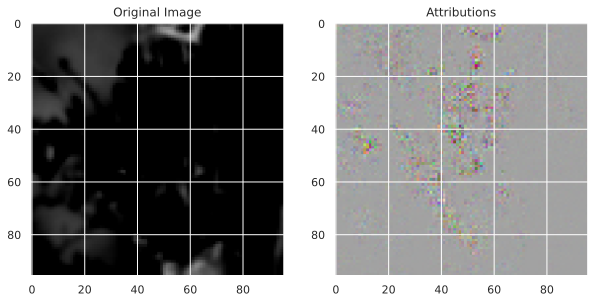

In [11]:
# Reinitialize the model
simclr_model = SimCLR()

# Load the saved state_dict
simclr_model.load_state_dict(torch.load("simclr_model.pth"))
simclr_model.eval()  # Set the model to evaluation mode

run_explainability(model=simclr_model)

In [ ]:
# run_explainability(model=mlp_model)